In [8]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import shutil
import os

import copy
import random
import time

In [9]:
(512)**(0.5)


22.627416997969522

In [10]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [11]:
import json

#create a JSON file to save the label

# label = {'no': 'Patient does not have tumor', 'yes': 'Patient has tumor'}
# with open('image_to_tumor.json', 'w') as f:
#     json.dump(label, f)

with open('image_to_tumor.json', 'r') as f:
    tumor_label = json.load(f)

In [13]:
IMG_PATH = '/home/jerry/Documents/Program/brain_tumor_dataset/'
dest='/home/jerry/Documents/Program/dest/'

## Making Directory
# os.mkdir(dest+'TRAIN')
# os.mkdir(dest+'TRAIN/YES')
# os.mkdir(dest+'TRAIN/NO')

# os.mkdir(dest+'VAL')
# os.mkdir(dest+'VAL/YES')
# os.mkdir(dest+'VAL/NO')

# os.mkdir(dest+'TEST')
# os.mkdir(dest+'TEST/YES')
# os.mkdir(dest+'TEST/NO')

# # split the data by train/val/test
# for CLASS in os.listdir(IMG_PATH):
#     if not CLASS.startswith('.'):
#         IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
#         for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
#             img = IMG_PATH + CLASS + '/' + FILE_NAME
#             if n < 5:
#                 shutil.copy(img, dest+'TEST/' + CLASS.upper() + '/' + FILE_NAME)
#             elif n < 0.8*IMG_NUM:
#                 shutil.copy(img, dest+'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
#             else:
#                 shutil.copy(img, dest+'VAL/'+ CLASS.upper() + '/' + FILE_NAME)


# TRAIN_DIR = dest+'TRAIN/'
# TEST_DIR =  dest+'TEST/'
# VAL_DIR =  dest+'VAL/'

In [14]:
train_dir = dest+'TRAIN/'
valid_dir = dest+'VAL/'
test_dir = dest+'TEST/'

# Different Data Augumentation Methods
### In the next two blocks, we use the 'torchvision.transforms

In [43]:

#Perform composed data augumentation

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

In [44]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<AxesSubplot:>

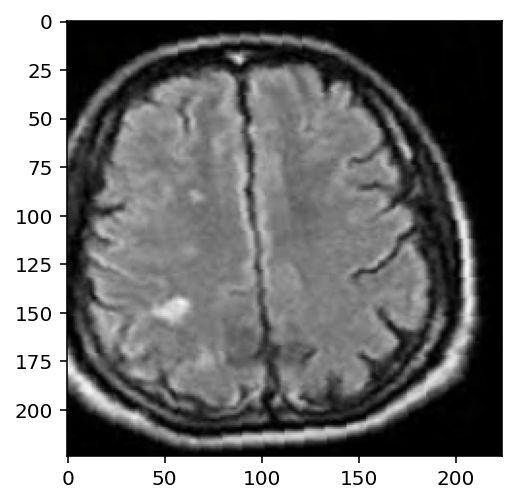

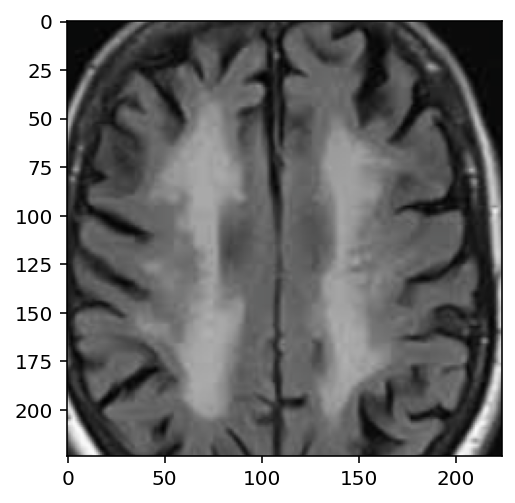

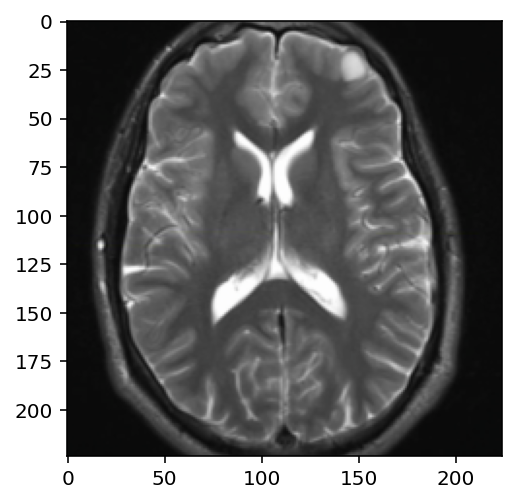

In [45]:
images, labels = next(iter(train_loader))
imshow(images[2])

images, labels = next(iter(valid_loader))
imshow(images[2])

images, labels = next(iter(test_loader))
imshow(images[2])

In [55]:
model = models.vgg16(pretrained=True)

In [56]:
for param in model.parameters():
    param.requires_grad = True

In [48]:
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 200)),
    ('relu', nn.ReLU()), 
    ('fc2', nn.Linear(200, 102)),
    ('drop', nn.Dropout(p=0.5)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [49]:
model.classifier = classifier

In [57]:
def save_checkpoint(state, is_best=False, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [60]:
gc.collect()
torch.cuda.empty_cache()

In [62]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
epochs = 60
print_every = 5
save_every = 50
steps = 0

for e in range(epochs):

    model.train()
    running_loss = 0
    accuracy_train = 0
    
    for images, labels in iter(train_loader):

        steps += 1
        
        inputs, labels = Variable(images), Variable(labels)
        
        optimizer.zero_grad()
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps_train = torch.exp(output).data
        equality_train = (labels.data == ps_train.max(1)[1])
        accuracy_train += equality_train.type_as(torch.FloatTensor()).mean()
        
        
        
        if steps % print_every == 0:
            model.eval()
            
            accuracy = 0
            valid_loss = 0
            
            for images, labels in valid_loader:
                with torch.no_grad():
                    inputs = Variable(images)
                    labels = Variable(labels)

                    if cuda:
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output = model.forward(inputs)

                    valid_loss += criterion(output, labels).item()

                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])

                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                
            print("Epoch: {}/{}.. ".format(e+1, epochs), 
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}..".format(valid_loss/len(valid_loader)),
                  "Training Accuracy: {:.3f}".format(accuracy_train/len(train_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
            
            running_loss = 0
            model.train()
            
        if steps % save_every == 0:
            print("Saving step number {}...".format(steps))
            state = {'state_dict': model.classifier.state_dict(),
                     'optimizer' : optimizer.state_dict(),
                     'class_to_idx':train_data.class_to_idx}
            
            save_checkpoint(state)
            print("Done!")
    gc.collect()
    torch.cuda.empty_cache()

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 7.79 GiB total capacity; 5.37 GiB already allocated; 29.25 MiB free; 5.42 GiB reserved in total by PyTorch)

In [34]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5060 MB |    5060 MB |    5118 MB |   59009 KB |\n|       from large pool |    5058 MB |    5058 MB |    5113 MB |   56950 KB |\n|       from small pool |       2 MB |       3 MB |       4 MB |    2058 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5060 MB |    5060 MB |    5118 MB |   59009 KB |\n|       from large pool |    5058 MB |    5058 MB |

In [37]:
import gc
